In [1]:
#import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


We're using online retail data from kaggle, you can download the data [here](https://www.kaggle.com/datasets/mashlyn/online-retail-ii-uci/code)

* InvoiceNo: Invoice number. Nominal. A 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'c', it indicates a cancellation.
* StockCode: Product (item) code. Nominal. A 5-digit integral number uniquely assigned to each distinct product.
* Description: Product (item) name. Nominal.
* Quantity: The quantities of each product (item) per transaction. Numeric.
* InvoiceDate: Invice date and time. Numeric. The day and time when a transaction was generated.
* UnitPrice: Unit price. Numeric. Product price per unit in sterling (Â£).
* CustomerID: Customer number. Nominal. A 5-digit integral number uniquely assigned to each customer.
Country: Country name. Nominal. The name of the country where a customer resides.

In [41]:
transactions = pd.read_csv('/content/gdrive/MyDrive/online_retail_II.csv')
transactions

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
...,...,...,...,...,...,...,...,...
1067366,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
1067367,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
1067368,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
1067369,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France


In [42]:
# Delete transaction with nan customer
transactions = transactions[transactions['Customer ID'].notna()]

# Delete items with quantity<1
transactions = transactions[transactions['Quantity']>1]

# Cut the data to focus on United Kingdom
transactions = transactions[transactions['Country']=='United Kingdom']

# Add Total Amount columns as a monetary
transactions['Total Amount'] = transactions['Quantity'] * transactions['Price']

transactions

<ipython-input-42-6dd7086cfff5>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transactions['Total Amount'] = transactions['Quantity'] * transactions['Price']


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Total Amount
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0
...,...,...,...,...,...,...,...,...,...
1067350,581585,22466,FAIRY TALE COTTAGE NIGHT LIGHT,12,2011-12-09 12:31:00,1.95,15804.0,United Kingdom,23.4
1067351,581586,22061,LARGE CAKE STAND HANGING STRAWBERY,8,2011-12-09 12:49:00,2.95,13113.0,United Kingdom,23.6
1067352,581586,23275,SET OF 3 HANGING OWLS OLLIE BEAK,24,2011-12-09 12:49:00,1.25,13113.0,United Kingdom,30.0
1067353,581586,21217,RED RETROSPOT ROUND CAKE TINS,24,2011-12-09 12:49:00,8.95,13113.0,United Kingdom,214.8


In [43]:
# Change data type
transactions['InvoiceDate'] = pd.to_datetime(transactions['InvoiceDate']).dt.date
# Add monthyear to cut off the data only in December 2009 (to align with price elasticity analysis)
transactions["monthyear"] = pd.to_datetime(transactions["InvoiceDate"]).dt.to_period('M').dt.to_timestamp()
transactions = transactions[transactions.monthyear=="2009-12-01"]

In [46]:
print("Unique Customers : ", transactions['Customer ID'].nunique())

Unique Customers :  898


## Remove Outliers of Total Amount

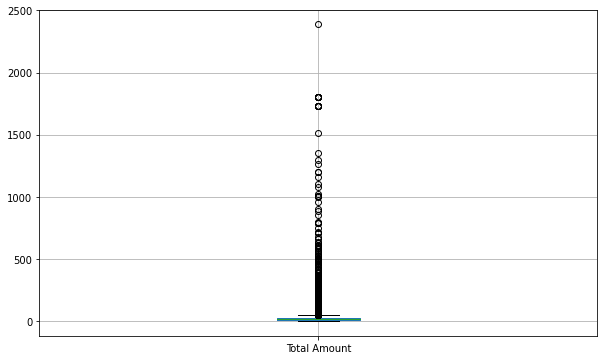

In [47]:
transactions.boxplot(column='Total Amount')

In [54]:
#Here is the application of best practice to remove outliers using quartile
q75,q25 = np.percentile(transactions['Total Amount'],[75,25])
intr_qr = q75-q25
 
max = q75+(1.5*intr_qr)
min = q25-(1.5*intr_qr)
 
transactions_no_outliers_quartile = transactions[(transactions['Total Amount']<max) & (transactions['Total Amount']>min)]
print("Unique customers after outliers removal with quartile: " , transactions_no_outliers_quartile['Customer ID'].nunique())

Unique customers after outliers removal with quartile:  854


There is many of outliers in the total amount, and with the best pratice technique there is 34 customers that removed from the data. But I want to segment all the customer, so I only removed transaction above 1500 and keep the rest of outliers.

In [55]:
transactions = transactions[transactions['Total Amount']<1500]
print("Unique customers after outliers removal >1500 total amount: " ,transactions['Customer ID'].nunique())

Unique customers after outliers removal >1500 total amount:  898


# Preprocessing for K-Means

In [63]:
#Because I use two variables, which is frequency and monetary to define the clusters. 
#I'll aggregate frequency from invoice count and monetary from total amount sum from each customer
transactions_groupby = transactions.groupby(['Customer ID']).agg({'Invoice':'nunique','Total Amount':'sum'}).reset_index()
transactions_groupby.rename(columns={'Invoice':'frequency', 'Total Amount':'monetary'}, inplace=True)
transactions_groupby

,Customer ID,frequency,monetary
0,12346.0,4,112.50
1,12747.0,3,1019.25
2,12748.0,7,1692.16
3,12820.0,1,148.30
4,12826.0,1,458.20
...,...,...,...
893,18268.0,1,375.18
894,18271.0,1,192.55
895,18275.0,1,372.64
896,18276.0,1,205.30


In [64]:
fm_data = transactions_groupby[['Customer ID', 'frequency', 'monetary']]
fm_data

,Customer ID,frequency,monetary
0,12346.0,4,112.50
1,12747.0,3,1019.25
2,12748.0,7,1692.16
3,12820.0,1,148.30
4,12826.0,1,458.20
...,...,...,...
893,18268.0,1,375.18
894,18271.0,1,192.55
895,18275.0,1,372.64
896,18276.0,1,205.30


In [65]:
#Scale the data because frequency and monetary has big different scale
scaler = MinMaxScaler()
fm_scaled = np.array(fm_data[['frequency', 'monetary']])
array_scaled = scaler.fit_transform(fm_scaled)
array_scaled

array([[0.21428571, 0.00498745],
       [0.14285714, 0.04939845],
       [0.42857143, 0.08235638],
       ...,
       [0.        , 0.01772865],
       [0.        , 0.00953263],
       [0.        , 0.01970296]])

In [66]:
fm_scaled = pd.DataFrame(array_scaled, columns=['frequency','monetary'])
cust = fm_data['Customer ID'].to_list()
fm_scaled['Customer ID'] = cust
fm_scaled

,frequency,monetary,Customer ID
0,0.214286,0.004987,12346.0
1,0.142857,0.049398,12747.0
2,0.428571,0.082356,12748.0
3,0.000000,0.006741,12820.0
4,0.000000,0.021919,12826.0
...,...,...,...
893,0.000000,0.017853,18268.0
894,0.000000,0.008908,18271.0
895,0.000000,0.017729,18275.0
896,0.000000,0.009533,18276.0


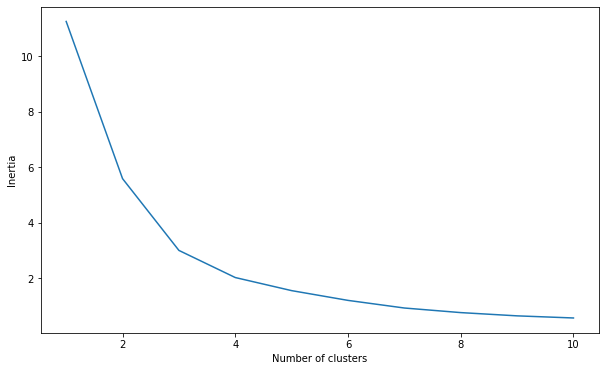

In [67]:
# Find K value using elbow method

# K-means
inertia = [] 
for i in range(1, 11): 
    k_model =  KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    k_model.fit(array_scaled)
    inertia.append(k_model.inertia_)

plt.rcParams["figure.figsize"] = [10, 6]
plt.plot(range(1, 11), inertia)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia') 
plt.show(inertia)

The elbow point is 3, so we used that for the K value

In [68]:
k_model = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)
k_model.fit(array_scaled)

predict_cluster = k_model.predict(array_scaled)

predict_cluster = pd.DataFrame(predict_cluster, columns=["predicted_cluster"])
result = pd.concat([fm_data,predict_cluster], axis=1)
result[['Customer ID','frequency','monetary', 'predicted_cluster']]

,Customer ID,frequency,monetary,predicted_cluster
0,12346.0,4,112.50,2
1,12747.0,3,1019.25,2
2,12748.0,7,1692.16,2
3,12820.0,1,148.30,0
4,12826.0,1,458.20,0
...,...,...,...,...
893,18268.0,1,375.18,0
894,18271.0,1,192.55,0
895,18275.0,1,372.64,0
896,18276.0,1,205.30,0


In [69]:
# cluster distribution
cluster_dist = result.groupby("predicted_cluster").agg({"Customer ID":"nunique","frequency":["min","max","mean"],\
                                                               "monetary":["min","max","mean"]}).reset_index()
cluster_dist

predicted_cluster Customer ID frequency                monetary            \
                        nunique       min max       mean      min       max   
0                 0         793         1   2   1.203026    10.67   4380.00   
1                 1           6         9  15  11.500000  5749.56  20427.91   
2                 2          99         2   8   3.757576    46.67   8367.81   

                 
           mean  
0    408.271980  
1  12254.028333  
2   1622.379798

**Cluster Description**
* Cluster 0 are interpeted as Low Cluster. There are 793 customers that has minimum frequency (only 1-2 transactions per customer) and monetary between 10 - 4380
* Cluster 1 are interpeted as High Cluster. There are only 6 customers that has high frequency (9-15 transactions per customer) and monetary between 5749 - 20427
* Cluster 2 are interpeted as Mid Cluster. There are 99 customers that has average frequency (2-18 transactions per customer) and monetary between 46.67 - 8367

**Information gained from the result**
* Majority of the customers are in Low cluster, means low frequency and total amount spending
* There only has 6 customers in High cluster, company should attract more high cluster if they want to increase our overall GMV

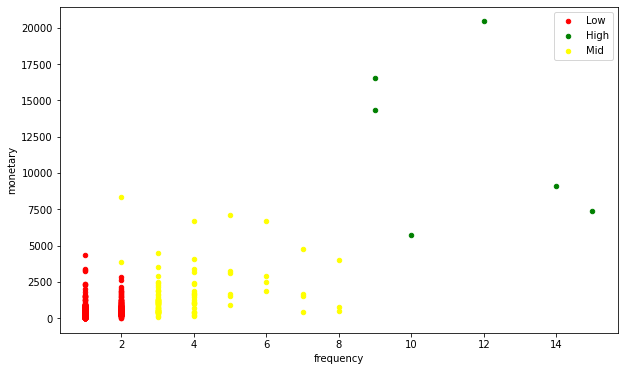

In [70]:
ax = result[result['predicted_cluster'] == 0].plot.scatter(x='frequency', y='monetary', c='red', label='Low')
ax = result[result['predicted_cluster'] == 1].plot.scatter(x='frequency', y='monetary', c='green', label='High', ax=ax)
ax = result[result['predicted_cluster'] == 2].plot.scatter(x='frequency', y='monetary', c='yellow', label='Mid', ax=ax)
ax

In [76]:
result['cluster'] = result['predicted_cluster'].map({0:'Low', 1:'High', 2:'Mid'})
result

,Customer ID,frequency,monetary,predicted_cluster,cluster
0,12346.0,4,112.50,2,Mid
1,12747.0,3,1019.25,2,Mid
2,12748.0,7,1692.16,2,Mid
3,12820.0,1,148.30,0,Low
4,12826.0,1,458.20,0,Low
...,...,...,...,...,...
893,18268.0,1,375.18,0,Low
894,18271.0,1,192.55,0,Low
895,18275.0,1,372.64,0,Low
896,18276.0,1,205.30,0,Low
